<a href="https://colab.research.google.com/github/AthuraThava/Group_5_Project_2/blob/LR/Collab_Algorithmic_Trading_Strategy_Optimization_for_FAANG_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas
!pip install yfinance
!pip install finta
!pip install plotly
!pip install scikit-learn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
# Import Libraries
import pandas as pd
import yfinance as yf
import finta
import plotly.graph_objects as go
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [20]:
def plot_SMA(stock_symbol):
    # Download historical data for the specified stock symbol
    df = yf.download(stock_symbol, start="2021-07-01", end="2023-06-01", interval="1h")
    #df = yf.download(stock_symbol, start="2023-05-10", end="2023-06-01", interval="5m")

    df["actual_returns"] = df['Close'].pct_change()

    # Compute SMAs
    df['SMA_9'] = df['Close'].rolling(window=9).mean()
    df['SMA_21'] = df['Close'].rolling(window=21).mean()

    # Compute EMA
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Create a Candlestick chart
    trace_candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

    # Dropping unnecessary columns
    df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    df.dropna(inplace=True)

    # Create traces for SMAs, EMA
    trace_sma_9 = go.Scatter(x=df.index, y=df['SMA_9'], line={'color': 'green'}, name='SMA 9')
    trace_sma_21 = go.Scatter(x=df.index, y=df['SMA_21'], line={'color': 'black'}, name='SMA 21')
    trace_ema_200 = go.Scatter(x=df.index, y=df['EMA_200'], line={'color': 'yellow'}, name='EMA 200')

    # Create layout
    layout = go.Layout(title=f'{stock_symbol} with SMAs and EMA 200',
                       xaxis=dict(title="Date"),
                       yaxis=dict(title="Price"),
                       width=1200,
                       height=800)

    # Create figure and add traces
    fig1 = go.Figure(data=[trace_candle, trace_sma_9, trace_sma_21, trace_ema_200], layout=layout)

    # Show the figure
    fig1.show()

    # Initialize the new Signal column
    df['signal'] = 0

    # Comparing elements element-wise and assigning signals
    df.loc[(df['SMA_9'] < df['EMA_200']) & (df['SMA_21'] < df['EMA_200']), 'signal'] = -1  # Sell signal
    df.loc[(df['SMA_9'] > df['EMA_200']) & (df['SMA_21'] > df['EMA_200']), 'signal'] = 1  # Buy signal

    print (df)

    # Copy the new signal column to a new Series called y.
    y = df["signal"].copy()

    # Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
    X = df[["SMA_9", "SMA_21", "EMA_200"]].copy()

    # Select the start of the training period
    training_begin = X.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=3) # 18 days for the 5 min df

    # Display the training end date
    print(training_end)

    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create the SVC model
    model = SVC()

    # Fit the model to the training data
    model.fit(X_train_scaled, y_train)

    # Use the trained model to predict the trading signals for the training data
    training_signal_predictions = model.predict(X_train_scaled)

    # Evaluate the model using a classification report
    training_report = classification_report(y_train, training_signal_predictions)
    print ("\nClassification_report: Training")
    print(training_report)

    # Use the trained model to predict the trading signals for the testing data
    testing_signal_predictions = model.predict(X_test_scaled)

    # Evaluate the model's ability to predict the trading signal for the testing data
    testing_report = classification_report(y_test, testing_signal_predictions)
    print ("\nClassification_report: Testing")
    print(testing_report)

    # Create a new empty predictions DataFrame
    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df["predicted_signal"] = testing_signal_predictions
    predictions_df["actual_returns"] = df["actual_returns"]
    predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
    print ("\nPredictions")
    print(predictions_df.head())

    # Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
    (1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot(kind='line')
    plt.show()

    # Logistic Regression
    # Initiate the model instance
    logistic_regression_model = LogisticRegression()

    # Fit the model using the training data
    model = logistic_regression_model.fit(X_train_scaled, y_train)

    # Use the testing dataset to generate the predictions for the new model
    pred = logistic_regression_model.predict(X_test_scaled)

    # Review the model's predicted values
    pred

    # Use a classification report to evaluate the model using the predictions and testing data
    signal_predictions = classification_report(y_test, pred)

    # Print the classification report
    print(signal_predictions)

    # Create a new empty predictions DataFrame.
    # Create a predictions DataFrame
    predictions_df_2 = pd.DataFrame(index=X_test.index)

    # Add the SVM model predictions to the DataFrame
    predictions_df_2['Predicted'] = pred

    # Add the actual returns to the DataFrame
    predictions_df_2["Actual Returns"] = df["actual_returns"]

    # Add the strategy returns to the DataFrame
    predictions_df_2['Strategy Returns'] = predictions_df_2["Actual Returns"] * pred

    # Review the DataFrame
    predictions_df_2

    # Plot the actual returns versus the strategy returns
    (1 + predictions_df_2[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2021-07-06 15:30:00-04:00       -0.000623  352.824439  352.610293  349.292532   
2021-07-07 09:30:00-04:00        0.005753  352.907772  352.914660  349.348328   
2021-07-07 10:30:00-04:00       -0.009862  352.551107  353.032517  349.368742   
2021-07-07 11:30:00-04:00        0.001195  352.281108  353.142994  349.393133   
2021-07-07 12:30:00-04:00       -0.001109  352.235552  353.163093  349.413400   
...                                   ...         ...         ...         ...   
2023-05-31 11:30:00-04:00       -0.003001  263.245521  260.265390  238.437093   
2023-05-31 12:30:00-04:00        0.003705  262.995409  260.628104  238.677520   
2023-05-31 13:30:00-04:00        0.004341  262.794298  261.099056  238.926898   
2023-05-31 14:30:00-04:00       -0.004095  262.627631  261.555246  239.163048   
2023-05-31 15:30:00-04:00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



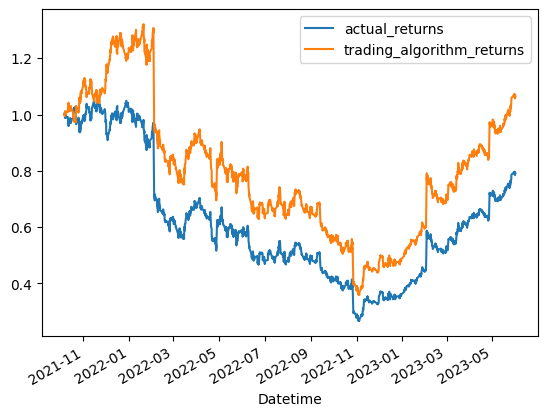

              precision    recall  f1-score   support

          -1       1.00      0.46      0.63      1538
           0       0.08      0.99      0.16       171
           1       0.99      0.14      0.24      1182

    accuracy                           0.36      2891
   macro avg       0.69      0.53      0.34      2891
weighted avg       0.94      0.36      0.44      2891



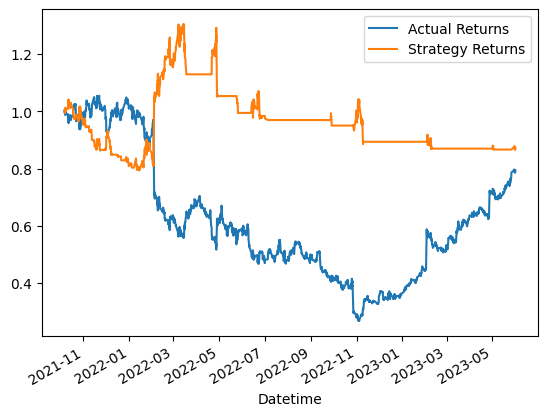

[*********************100%***********************]  1 of 1 completed


                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2021-07-06 15:30:00-04:00       -0.000633  141.379035  139.268481  137.097782   
2021-07-07 09:30:00-04:00        0.012428  141.835702  139.612476  137.164322   
2021-07-07 10:30:00-04:00       -0.002330  142.223479  139.966524  137.226866   
2021-07-07 11:30:00-04:00        0.002823  142.330144  140.321524  137.292817   
2021-07-07 12:30:00-04:00        0.002329  142.595145  140.698662  137.361446   
...                                   ...         ...         ...         ...   
2023-05-31 11:30:00-04:00        0.002370  177.667781  176.031658  170.886308   
2023-05-31 12:30:00-04:00        0.000824  177.851113  176.302611  170.965947   
2023-05-31 13:30:00-04:00        0.001565  178.067525  176.579749  171.047578   
2023-05-31 14:30:00-04:00       -0.002523  178.241737  176.821792  171.123900   
2023-05-31 15:30:00-04:00   

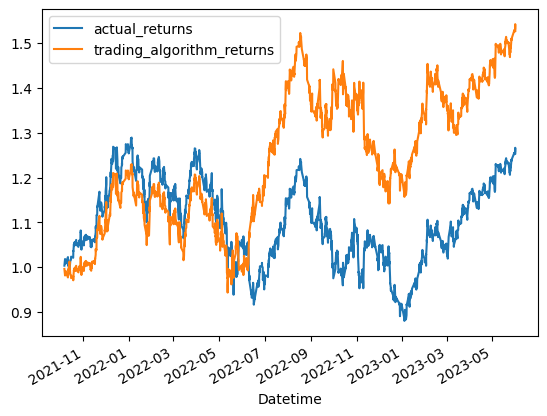

              precision    recall  f1-score   support

          -1       0.97      0.63      0.76      1166
           0       0.06      0.48      0.11       156
           1       0.92      0.56      0.69      1569

    accuracy                           0.58      2891
   macro avg       0.65      0.55      0.52      2891
weighted avg       0.90      0.58      0.69      2891



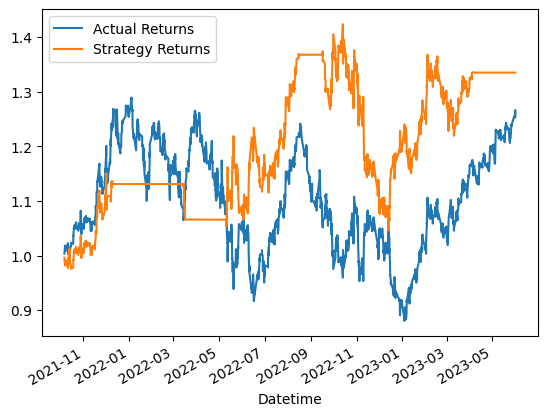

[*********************100%***********************]  1 of 1 completed


                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2021-07-06 15:30:00-04:00       -0.001068  180.896235  175.877164  172.724242   
2021-07-07 09:30:00-04:00        0.004165  181.973346  176.478545  172.841926   
2021-07-07 10:30:00-04:00        0.001490  183.004125  177.135438  172.961175   
2021-07-07 11:30:00-04:00        0.002127  183.455512  177.813562  173.083150   
2021-07-07 12:30:00-04:00       -0.001183  183.789902  178.484919  173.201730   
...                                   ...         ...         ...         ...   
2023-05-31 11:30:00-04:00       -0.002468  120.916765  119.588537  111.350879   
2023-05-31 12:30:00-04:00        0.007215  120.741654  119.849490  111.437338   
2023-05-31 13:30:00-04:00        0.001833  120.624988  120.105681  111.525126   
2023-05-31 14:30:00-04:00       -0.001705  120.473333  120.342347  111.610000   
2023-05-31 15:30:00-04:00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



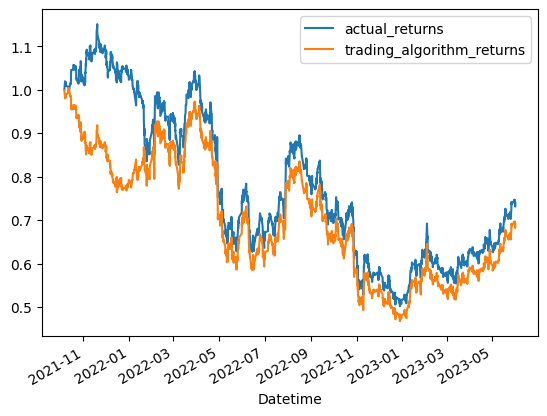

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          -1       0.63      1.00      0.77      1561
           0       0.00      0.00      0.00       184
           1       0.95      0.34      0.50      1146

    accuracy                           0.67      2891
   macro avg       0.53      0.45      0.42      2891
weighted avg       0.72      0.67      0.61      2891



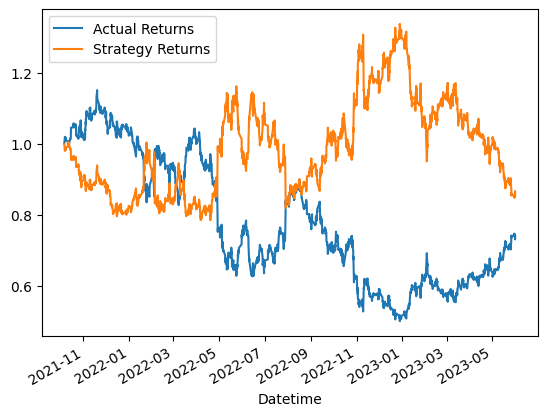

[*********************100%***********************]  1 of 1 completed


                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2021-07-06 15:30:00-04:00       -0.000480  538.464437  535.360186  536.558391   
2021-07-07 09:30:00-04:00       -0.008087  538.896661  535.381615  536.565272   
2021-07-07 10:30:00-04:00       -0.003760  539.046658  535.545425  536.551986   
2021-07-07 11:30:00-04:00        0.001448  538.913893  535.733759  536.546543   
2021-07-07 12:30:00-04:00       -0.001614  538.477227  535.849949  536.532548   
...                                   ...         ...         ...         ...   
2023-05-31 11:30:00-04:00       -0.004579  392.519141  380.861885  348.809931   
2023-05-31 12:30:00-04:00        0.001047  391.953030  382.117360  349.235504   
2023-05-31 13:30:00-04:00        0.008657  392.437585  383.646675  349.690573   
2023-05-31 14:30:00-04:00       -0.001089  392.737586  385.292389  350.136836   
2023-05-31 15:30:00-04:00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

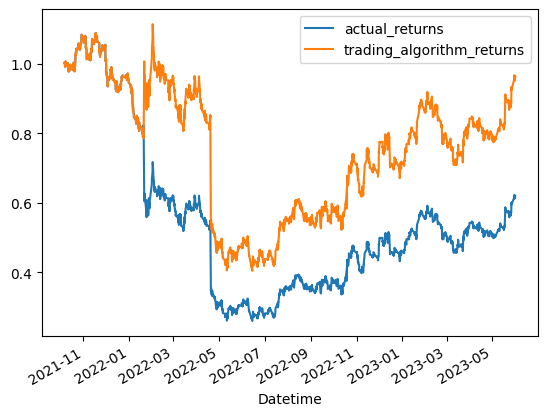

              precision    recall  f1-score   support

          -1       0.51      0.87      0.64      1428
           0       0.00      0.00      0.00       183
           1       0.55      0.19      0.28      1270

    accuracy                           0.52      2881
   macro avg       0.35      0.35      0.31      2881
weighted avg       0.50      0.52      0.44      2881



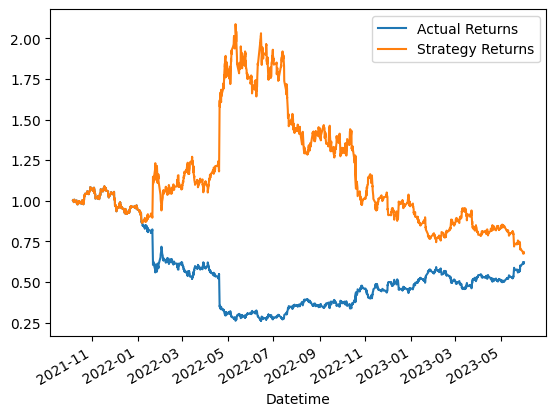

[*********************100%***********************]  1 of 1 completed


                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2021-07-06 15:30:00-04:00        0.000640  129.227632  127.908885  126.284675   
2021-07-07 09:30:00-04:00        0.002689  129.393855  128.110575  126.322842   
2021-07-07 10:30:00-04:00       -0.001652  129.527466  128.318626  126.358490   
2021-07-07 11:30:00-04:00       -0.000701  129.582562  128.517531  126.392878   
2021-07-07 12:30:00-04:00        0.001749  129.680284  128.736722  126.429183   
...                                   ...         ...         ...         ...   
2023-05-31 11:30:00-04:00        0.000560  124.339066  124.660556  116.072265   
2023-05-31 12:30:00-04:00        0.002182  124.236844  124.640556  116.151546   
2023-05-31 13:30:00-04:00       -0.001250  124.112955  124.633647  116.228496   
2023-05-31 14:30:00-04:00        0.001251  124.100733  124.621504  116.306222   
2023-05-31 15:30:00-04:00   

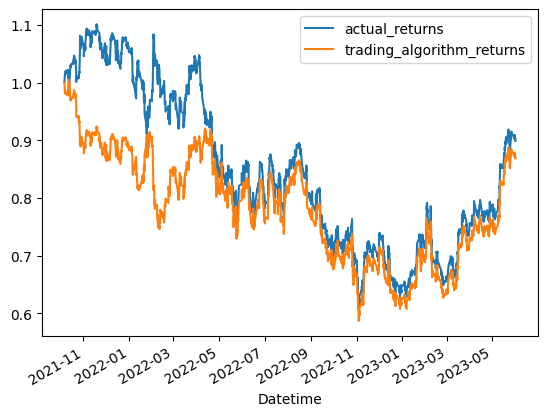

              precision    recall  f1-score   support

          -1       0.99      0.88      0.93      1493
           0       0.28      0.15      0.20       229
           1       0.79      0.97      0.88      1169

    accuracy                           0.86      2891
   macro avg       0.69      0.67      0.67      2891
weighted avg       0.85      0.86      0.85      2891



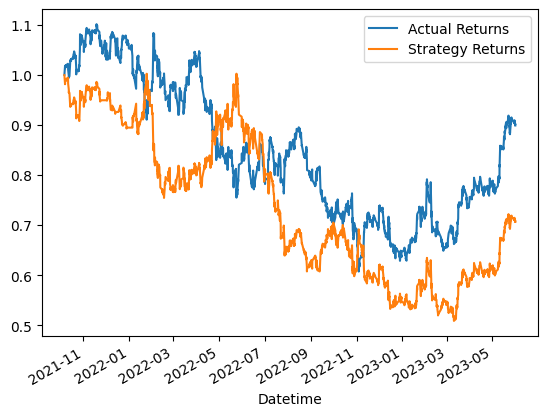

In [21]:
# Import Data from Yahoo Finance
stocks = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
dfs = {}

start_date = "2021-07-01"
# start_date = "2023-05-10" for the 5min df
end_date = "2023-06-01"

for stock in stocks:
    dfs[stock] = yf.download(stock, start=start_date, end=end_date, interval="1h")
    # dfs[stock] = yf.download(stock, start=start_date, end=end_date, interval="5m")

# Plotting SMAs for each stock
for stock, df in dfs.items():
    plot_SMA(stock)